<a href="https://colab.research.google.com/github/AtanasSpirtov/Fine_tuning_bert_for_sentiment/blob/main/Test_fine_tune_bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q tf-models-official
%matplotlib inline

In [2]:
import pandas as pd
import tensorflow as tf
import tensorflow_models as tfm
import os
import tensorflow_hub as tf_hub
from official.nlp import optimization
from official.nlp.data import classifier_data_lib
from transformers import BertTokenizer
from tensorflow.keras.layers import Input, Dropout, Dense, LSTM
from official.nlp.tools import tokenization
import matplotlib.pyplot as plt

In [3]:
data = pd.read_csv("ranked_and_filtered_news.csv")

In [4]:
data

,title,publish_date,text,rank
0,Latest Bitcoin News,NaN,[{'summary_text': 'Bitcoin is the first peer-t...,neutral
1,Latest Ethereum News,NaN,[{'summary_text': 'Ethereum News is the larges...,neutral
2,Latest DeFi News,NaN,"[{'summary_text': 'DeFi, or decentralized fina...",neutral
3,Breaking Altcoin News Today,NaN,[{'summary_text': 'Take a look at the list of ...,neutral
4,Blockchain Altcoin News,NaN,[{'summary_text': 'In Blockchain News you can ...,neutral
...,...,...,...,...
639,Bitcoin Price Correction Imminent as Miners En...,2024-01-10 10:22:06+00:00,"[{'summary_text': 'In the past 13 weeks, there...",negative
640,Ethereum Outperforms as Crypto Markets Navigat...,2024-01-10 07:52:10+00:00,[{'summary_text': 'Crypto markets have fallen ...,positive
641,Could Polygon (MATIC) Emerge as a Dark Horse i...,2024-01-10 07:51:18+00:00,[{'summary_text': 'Polygon proof-of-stake (POS...,positive
642,Coinbase Extends Offer to Assist SEC With Cybe...,2024-01-10 06:31:10+00:00,[{'summary_text': 'Coinbase has offered to hel...,neutral


## REMOVE JUNK FROM EVERY TEXT ROW

In [5]:
def remove_junk_from_sentence(data):
  data.str.replce

In [6]:
text_data_with_labels = data.drop(columns=['title', 'publish_date'])
text_data_with_labels["text"] = text_data_with_labels["text"].str.replace(r"\[{'summary_text': ", "", regex=True)
text_data_with_labels["text"] = text_data_with_labels["text"].str.replace(r"}]", "", regex=True)

In [7]:
labels = text_data_with_labels["rank"].unique()

In [8]:
label_mapping = {'very negative': 1, 'negative': 2, 'neutral': 3, 'positive': 4, 'very positive': 5}
text_data_with_labels['rank'] = text_data_with_labels['rank'].map(label_mapping)
sentences = text_data_with_labels["text"]
labels = text_data_with_labels["rank"]

## PREPROCESS

In [9]:
text_data_with_labels['text'] = text_data_with_labels['text'].str.lower()

In [10]:
text_data_with_labels['text'] = text_data_with_labels['text'].str.replace('[^a-zA-Z0-9\s]', '', regex=True)

## Splitting the data

In [11]:
train_size = int(0.8 * len(sentences))
val_size = int(0.1 * len(sentences))
test_size = len(sentences) - train_size - val_size
train_size, val_size, test_size

(515, 64, 65)

In [12]:
X_train, y_train = sentences[:train_size], labels[:train_size]
X_val, y_val = sentences[train_size:train_size + val_size], labels[train_size:train_size + val_size]
X_test, y_test = sentences[train_size + val_size:], labels[train_size + val_size:]


In [13]:
training_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
validation_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [14]:
batch_size = 2 # This is the recommended size for BERT model. Other possible size is 16 but 32 will be better in our use case

## Fine tuning

In [15]:
total_characters = sum(len(X_train) for sentence in X_train)
average_character_length = total_characters / len(X_train)
average_character_length

515.0

In [16]:
max_seq_length = 512

In [17]:
bert_model_layer = tf_hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2",
                            trainable=True)

In [18]:
vocab_file = bert_model_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_model_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)


In [19]:
def to_feature(text, label, label_list=sorted(y_train.unique()), max_seq_length=max_seq_length, tokenizer=tokenizer):
  example = classifier_data_lib.InputExample(guid = None,
                                            text_a = text.numpy(),
                                            text_b = None,
                                            label = label.numpy())
  feature = classifier_data_lib.convert_single_example(0, example, label_list,
                                    max_seq_length, tokenizer)

  return (feature.input_ids, feature.input_mask, feature.segment_ids, feature.label_id)


In [20]:
def to_feature_map(text, label):
  input_ids, input_mask, segment_ids, label_id = tf.py_function(to_feature, inp=[text, label],
                                Tout=[tf.int32, tf.int32, tf.int32, tf.int32])

  # py_func doesn't set the shape of the returned tensors.
  input_ids.set_shape([max_seq_length])
  input_mask.set_shape([max_seq_length])
  segment_ids.set_shape([max_seq_length])
  label_id.set_shape([])

  x = {
        'input_word_ids': input_ids,
        'input_mask': input_mask,
        'input_type_ids': segment_ids
    }
  return (x, label_id)

In [21]:
  train_data = (training_dataset.map(to_feature_map)
                          .shuffle(len(X_train))
                          .batch(batch_size, drop_remainder=True)
                          .prefetch(tf.data.experimental.AUTOTUNE))

  valid_data = (validation_dataset.map(to_feature_map)
                          .batch(batch_size, drop_remainder=True)
                          .prefetch(tf.data.experimental.AUTOTUNE))
  test_data = (test_dataset.map(to_feature_map)
                          .batch(batch_size, drop_remainder=True)
                          .prefetch(tf.data.experimental.AUTOTUNE))

In [41]:
def create_model():
  input_word_ids = Input(shape=(max_seq_length,), dtype=tf.int32,
                                      name="input_word_ids")
  input_mask = Input(shape=(max_seq_length,), dtype=tf.int32,
                                  name="input_mask")
  input_type_ids = Input(shape=(max_seq_length,), dtype=tf.int32, name="input_type_ids")

  pooled_output, sequence_output = bert_model_layer([input_word_ids, input_mask, input_type_ids])

  lstm_layer = LSTM(194, activation= "sigmoid", return_sequences=False)(sequence_output)
  drop = Dropout(0.2)(lstm_layer)
  output = Dense(5, activation="softmax", name="output")(lstm_layer)

  model = tf.keras.Model(
    inputs={
        'input_word_ids': input_word_ids,
        'input_mask': input_mask,
        'input_type_ids': input_type_ids
    },
    outputs=output)
  return model

In [34]:
model = create_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5, clipnorm=1.0),
                     loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                     metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_word_ids (InputLayer  [(None, 512)]                0         []                            
 )                                                                                                
                                                                                                  
 input_mask (InputLayer)     [(None, 512)]                0         []                            
                                                                                                  
 input_type_ids (InputLayer  [(None, 512)]                0         []                            
 )                                                                                                
                                                                                              

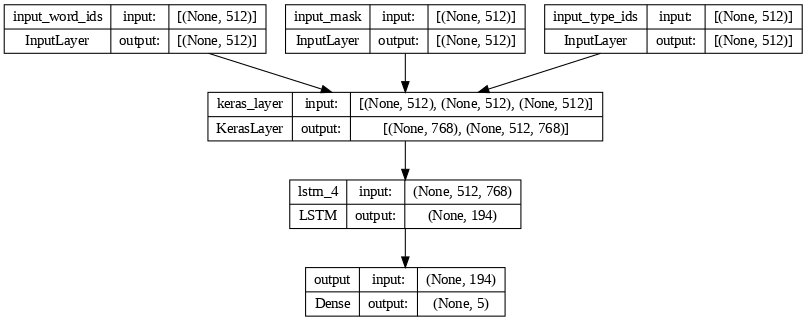

In [35]:
tf.keras.utils.plot_model(model=model,show_shapes=True,dpi=76)

In [36]:
train_data

<_PrefetchDataset element_spec=({'input_word_ids': TensorSpec(shape=(2, 512), dtype=tf.int32, name=None), 'input_mask': TensorSpec(shape=(2, 512), dtype=tf.int32, name=None), 'input_type_ids': TensorSpec(shape=(2, 512), dtype=tf.int32, name=None)}, TensorSpec(shape=(2,), dtype=tf.int32, name=None))>

In [37]:
# Train model
epochs=4
history = model.fit(train_data,
                    validation_data=valid_data,
                    epochs=epochs,
                    verbose=1)


Epoch 1/4
257/257 [==============================] - 256s 812ms/step - loss: 1.2815 - sparse_categorical_accuracy: 0.4903 - val_loss: 1.4411 - val_sparse_categorical_accuracy: 0.3125
Epoch 2/4
257/257 [==============================] - 206s 796ms/step - loss: 0.8399 - sparse_categorical_accuracy: 0.6634 - val_loss: 0.7913 - val_sparse_categorical_accuracy: 0.6875
Epoch 3/4
257/257 [==============================] - 205s 791ms/step - loss: 0.4295 - sparse_categorical_accuracy: 0.8327 - val_loss: 0.2383 - val_sparse_categorical_accuracy: 0.9688
Epoch 4/4
257/257 [==============================] - 207s 800ms/step - loss: 0.1632 - sparse_categorical_accuracy: 0.9533 - val_loss: 0.0895 - val_sparse_categorical_accuracy: 0.9688


In [38]:
model.evaluate(test_data)

32/32 [==============================] - 5s 141ms/step - loss: 0.0746 - sparse_categorical_accuracy: 0.9688


[0.07464268803596497, 0.96875]

In [39]:
train_loss = history.history['loss']
train_accuracy = history.history['sparse_categorical_accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_sparse_categorical_accuracy']
history.history

{'loss': [1.2815444469451904,
  0.8398787975311279,
  0.42949730157852173,
  0.1631738245487213],
 'sparse_categorical_accuracy': [0.4902723729610443,
  0.6634241342544556,
  0.8326848149299622,
  0.9533073902130127],
 'val_loss': [1.4411345720291138,
  0.7913458347320557,
  0.2382677048444748,
  0.08951431512832642],
 'val_sparse_categorical_accuracy': [0.3125, 0.6875, 0.96875, 0.96875]}

In [40]:
plt.plot(train_loss, label='Training ')
plt.plot(val_loss, label='Validation ')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.show()